In [2]:
# !conda install -c rdkit rdkit --yes


In [3]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd

In [4]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
import pandas as pd

kinase count: 392
similes count: 2140
number of all smiles:  2140
number of successfully processed smiles:  2140


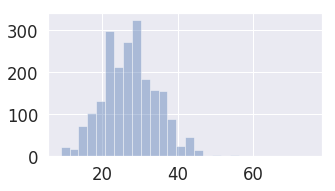

In [5]:
task_name = 'Multi-Targeting'
tasks = ['activity']
sub_task1 = ['RET','MKNK1','BRAF','SRC','RPS6KB1','TTK','MAPK15','PDPK1','PAK3']
sub_task2 = ['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','PIK3CA']
kinase_seq_embedding = pd.read_csv('../input/kinase_seq_embedding.csv')
smiles_kinase_activity = pd.read_csv('../input/smiles_kinase_activity.csv')
print('kinase count:',len(smiles_kinase_activity['kinase'].value_counts()))
print('similes count:',len(smiles_kinase_activity['smiles'].value_counts()))

# seq_embeddings_dict = {}
# for kinase in list(set(smiles_kinase_activity['kinase'].values)):
#     seq_embeddings_dict[kinase] = [float(x) for x in kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0]\
#                                  .replace("[", "").replace("]", "").replace(" ", "").split(',')]

# smiles_kinase_activity['embedding'] = [seq_embeddings_dict[kinase] for kinase in smiles_kinase_activity['kinase'].values]

smilesList = list(set(smiles_kinase_activity.smiles.values))
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [6]:
multi_tasks = list(smiles_kinase_activity['kinase'].unique())

In [7]:
multi_tasks

['EPHA5',
 'EPHA8',
 'EPHB1',
 'EPHB2',
 'EPHB3',
 'EPHB4',
 'EPHB6',
 'ABL1',
 'TNK2',
 'BRSK2',
 'WNK2',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'ACVRL1',
 'ACVR1',
 'BMPR1A',
 'ACVR1B',
 'TGFBR1',
 'BMPR1B',
 'DAPK1',
 'AURKC',
 'AXL',
 'GRK2',
 'MAP4K2',
 'BLK',
 'BRAF',
 'PTK6',
 'BTK',
 'CDK7',
 'CAMK1',
 'EGFR',
 'CAMK2A',
 'CAMK2B',
 'CAMK2G',
 'CAMK4',
 'CDK1',
 'CDC7',
 'EPHA4',
 'CDK2',
 'CDK3',
 'CDK4',
 'CDK5',
 'CDK6',
 'PRKG1',
 'PRKG2',
 'CHEK1',
 'CHEK2',
 'CSNK1A1',
 'CSNK1D',
 'JAK1',
 'CSNK1E',
 'CSNK1G2',
 'CSNK1G3',
 'CSNK2A1',
 'CLK1',
 'CLK2',
 'CLK3',
 'JAK2',
 'MAP3K8',
 'CSF1R',
 'CSK',
 'MARK3',
 'MAP3K12',
 'DMPK',
 'PRKDC',
 'DYRK1B',
 'DYRK2',
 'DYRK4',
 'EEF2K',
 'EIF2AK2',
 'MARK2',
 'EPHA1',
 'EPHA2',
 'EPHA3',
 'MAPK3',
 'MAPK1',
 'PTK2',
 'FER',
 'FES',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FGFR4',
 'FGR',
 'FLT3',
 'FLT1',
 'FLT4',
 'MTOR',
 'FYN',
 'GRK4',
 'GRK5',
 'GRK6',
 'GSK3A',
 'JAK3',
 'GSK3B',
 'HCK',
 'ERBB2',
 'ERBB4',
 'HIPK1',
 'IGF1R',
 'CHUK',

In [8]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 100

layers = 3
fingerprint_dim = 500

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2
output_units_num = 1 * len(multi_tasks)# for regression model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):

    def __init__(self, fingerprint_dim, layers, output_units_num):
        super(Model, self).__init__()
        self.hidden = nn.ModuleList([nn.Linear(fingerprint_dim, fingerprint_dim) for _ in range(layers)])
        self.output = nn.Linear(fingerprint_dim, output_units_num)
        self.layers = layers

    def forward(self, fingerprints):
        for i in range(self.layers):
            fingerprints = F.relu(self.hidden[i](fingerprints))
        mol_prediction = self.output(fingerprints)
            
        return mol_prediction

In [10]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem

def smiles_to_fps(data, fp_length, fp_radius=2):
    return stringlist2intarray(np.array([smile_to_fp(s, fp_length, fp_radius) for s in data]))

def smile_to_fp(s, fp_length, fp_radius):
    m = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(
        m, fp_radius, nBits=fp_length)).ToBitString()

def stringlist2intarray(A):
    return np.array([list(s) for s in A], dtype=int)

fingerprints = smiles_to_fps(smiles_kinase_activity['smiles'].values, fingerprint_dim)
smiles_kinase_activity['fingerprints'] = [list(i) for i in fingerprints]

In [12]:
loss_function = nn.MSELoss()
model = Model(fingerprint_dim, layers, output_units_num)
model.cuda()
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)


In [35]:
test_df = smiles_kinase_activity.sample(frac=1/10, random_state=random_seed) # test set
training_data = smiles_kinase_activity.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22636,0.79216,0.572409,1.383907


In [36]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = smiles_kinase_activity.groupby('smiles')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/smiles_kinase_activity.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = smiles_kinase_activity.groupby('kinase')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/smiles_kinase_activity.shape[0]))

0.6067693844481934
0.7473647274436619


In [37]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = training_data.groupby('smiles')['activity'].var(ddof=0) * training_data.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/training_data.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = training_data.groupby('kinase')['activity'].var(ddof=0) * training_data.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/training_data.shape[0]))

0.6055113264956725
0.7465290722867107


In [38]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

947892
hidden.0.weight torch.Size([500, 500])
hidden.0.bias torch.Size([500])
hidden.1.weight torch.Size([500, 500])
hidden.1.bias torch.Size([500])
hidden.2.weight torch.Size([500, 500])
hidden.2.bias torch.Size([500])
output.weight torch.Size([392, 500])
output.bias torch.Size([392])


In [42]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
#         seq_embeddings = list(batch_df.embedding.values)
        tasks_mask = torch.cuda.ByteTensor([np.array([x == task for task in multi_tasks]) for x in batch_df['kinase']])
        mol_prediction = model(torch.Tensor(list(batch_df['fingerprints'].values)))
        mol_prediction = torch.masked_select(mol_prediction, tasks_mask)
        
        model.zero_grad()
        # Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = loss_function(mol_prediction, torch.Tensor(y_val))
        print(loss)
        # Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_val = batch_df['activity_normalized'].values
        
        tasks_mask = torch.cuda.ByteTensor([np.array([x == task for task in multi_tasks]) for x in batch_df['kinase']])
        mol_prediction = model(torch.Tensor(list(batch_df['fingerprints'].values)))        
        mol_prediction = torch.masked_select(mol_prediction, tasks_mask)
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val), reduction='none')
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val), reduction='none')
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    eval_MAE_nomalized = np.array(eval_MAE_list).mean()
    eval_MSE_nomalized = np.array(eval_MSE_list).mean()
    eval_MAE = eval_MAE_nomalized * std_list[0]
    eval_MSE = eval_MSE_nomalized * std_list[0] * std_list[0]
    return eval_MAE, eval_MSE

In [43]:
for epoch in range(60):
    valid_MAE, valid_MSE = eval(model, valid_df)
    train_MAE, train_MSE = eval(model, train_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
   
    %time train(model, train_df, optimizer, loss_function)


0 0.7916718941900965 0.795276485690604
CPU times: user 27.7 s, sys: 168 ms, total: 27.8 s
Wall time: 27.9 s
1 0.7479210083804481 0.7550478559843463
CPU times: user 28.1 s, sys: 148 ms, total: 28.2 s
Wall time: 28.3 s
2 0.7471352499763476 0.7545078555755179
CPU times: user 27.7 s, sys: 188 ms, total: 27.9 s
Wall time: 27.9 s
3 0.7469307943587368 0.7542873240030664
CPU times: user 27.5 s, sys: 152 ms, total: 27.7 s
Wall time: 27.7 s
4 0.7467005113777387 0.7539873858510072
CPU times: user 27.5 s, sys: 180 ms, total: 27.7 s
Wall time: 27.7 s
5 0.7468902070045133 0.7537109750692863
CPU times: user 27.7 s, sys: 184 ms, total: 27.9 s
Wall time: 27.9 s
6 0.7467267335640903 0.7541282563260066
CPU times: user 27.5 s, sys: 192 ms, total: 27.7 s
Wall time: 27.8 s
7 0.7469530025449747 0.7543833682709522
CPU times: user 27.5 s, sys: 180 ms, total: 27.7 s
Wall time: 27.7 s
8 0.7467615447861513 0.7538998989831791
CPU times: user 27.6 s, sys: 148 ms, total: 27.8 s
Wall time: 27.8 s
9 0.6849872768500895

In [44]:
for epoch in range(60,150):
    valid_MAE, valid_MSE = eval(model, valid_df)
    train_MAE, train_MSE = eval(model, train_df)
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
   
    %time train(model, train_df, optimizer, loss_function)


60 0.5269524799673178 0.553279599124005
CPU times: user 27.6 s, sys: 120 ms, total: 27.8 s
Wall time: 27.8 s
61 0.5224790474466388 0.5494352703918886
CPU times: user 27.5 s, sys: 180 ms, total: 27.7 s
Wall time: 27.7 s
62 0.5187573612376194 0.5463355321474553
CPU times: user 27.6 s, sys: 160 ms, total: 27.8 s
Wall time: 27.8 s
63 0.5227278264902651 0.5494537865695379
CPU times: user 27.4 s, sys: 148 ms, total: 27.6 s
Wall time: 27.6 s
64 0.5181603268263854 0.5461489253907957
CPU times: user 27.5 s, sys: 208 ms, total: 27.7 s
Wall time: 27.8 s
65 0.5184128378047016 0.5448853372082901
CPU times: user 27.4 s, sys: 232 ms, total: 27.6 s
Wall time: 27.6 s
66 0.5199966510926546 0.5472969477878535
CPU times: user 27.6 s, sys: 188 ms, total: 27.7 s
Wall time: 27.8 s
67 0.5172944215734122 0.5458148391813858
CPU times: user 27.5 s, sys: 172 ms, total: 27.7 s
Wall time: 27.7 s
68 0.5145917395018107 0.5428862814076632
CPU times: user 27.5 s, sys: 152 ms, total: 27.7 s
Wall time: 27.7 s
69 0.517381

CPU times: user 27.6 s, sys: 160 ms, total: 27.7 s
Wall time: 27.8 s
135 0.4862470316248462 0.5255694689484869
CPU times: user 27.4 s, sys: 148 ms, total: 27.5 s
Wall time: 27.5 s
136 0.48838280498643166 0.5268812469129524
CPU times: user 27.6 s, sys: 140 ms, total: 27.7 s
Wall time: 27.7 s
137 0.48860676589778546 0.526295969128337
CPU times: user 27.7 s, sys: 140 ms, total: 27.9 s
Wall time: 27.9 s
138 0.48919435704667835 0.5252893181658441
CPU times: user 27.4 s, sys: 184 ms, total: 27.6 s
Wall time: 27.6 s
139 0.4901016305053089 0.5241411182567416
CPU times: user 27.4 s, sys: 140 ms, total: 27.6 s
Wall time: 27.6 s
140 0.48703219215357335 0.5239828345452137
CPU times: user 27.5 s, sys: 156 ms, total: 27.7 s
Wall time: 27.7 s
141 0.4918049615408757 0.527096513807903
CPU times: user 27.9 s, sys: 192 ms, total: 28 s
Wall time: 28.1 s
142 0.49048083552821997 0.5277655829380985
CPU times: user 27.3 s, sys: 204 ms, total: 27.5 s
Wall time: 27.5 s
143 0.4875119611193814 0.5248415889861328
